<a href="https://colab.research.google.com/github/daeIy/Normal-vs-Pneumonia/blob/master/Pneumonia_vs_Normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
# Upload Kaggle API key

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabrieldaely","key":"26bf1049d09710bdea490aa8549a8716"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d 'paultimothymooney/chest-xray-pneumonia'

100% 2.29G/2.29G [00:29<00:00, 32.6MB/s]
100% 2.29G/2.29G [00:29<00:00, 82.8MB/s]


In [5]:
! ls

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [6]:
! unzip -q chest-xray-pneumonia.zip
! rm -r chest-xray-pneumonia.zip

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

In [8]:
print(len(os.listdir('./chest_xray/train/NORMAL')))
print(len(os.listdir('./chest_xray/train/PNEUMONIA')))
print(len(os.listdir('./chest_xray/test/NORMAL')))
print(len(os.listdir('./chest_xray/test/PNEUMONIA')))
print(len(os.listdir('./chest_xray/val/NORMAL')))
print(len(os.listdir('./chest_xray/val/PNEUMONIA')))

1341
3875
234
390
8
8


In [12]:
TRAIN_DIR = './chest_xray/train'
VAL_DIR = './chest_xray/test'

# Create train data generator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
	TRAIN_DIR,
	target_size=(224,224),
	class_mode='binary',
    batch_size=32
)

# Create validation data generator
val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_directory(
	VAL_DIR,
	target_size=(224,224),
	class_mode='binary',
    batch_size=32
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
densenet = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in densenet.layers:
	layer.trainable = False

mod1 = densenet.output
mod1 = MaxPooling2D()(mod1)
mod1 = Flatten()(mod1)
mod1 = Dense(64, activation="relu")(mod1)
mod1 = Dropout(0.5)(mod1)
mod1 = Dense(1, activation="sigmoid")(mod1)

model = Model(inputs=densenet.input, outputs=mod1)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
history = model.fit(train_generator, epochs = 30, 
                    validation_data = val_generator,
                    verbose = 1)

Epoch 1/30
163/163 [==============================] - 131s 806ms/step - loss: 0.4866 - accuracy: 0.8376 - val_loss: 0.5402 - val_accuracy: 0.7260
Epoch 2/30
163/163 [==============================] - 128s 785ms/step - loss: 0.2562 - accuracy: 0.8972 - val_loss: 0.3670 - val_accuracy: 0.8205
Epoch 3/30
163/163 [==============================] - 128s 788ms/step - loss: 0.2340 - accuracy: 0.9045 - val_loss: 0.4864 - val_accuracy: 0.7821
Epoch 4/30
163/163 [==============================] - 130s 796ms/step - loss: 0.2501 - accuracy: 0.9114 - val_loss: 0.3098 - val_accuracy: 0.8878
Epoch 5/30
163/163 [==============================] - 129s 793ms/step - loss: 0.2207 - accuracy: 0.9151 - val_loss: 0.2820 - val_accuracy: 0.9038
Epoch 6/30
163/163 [==============================] - 129s 794ms/step - loss: 0.2372 - accuracy: 0.8959 - val_loss: 0.3881 - val_accuracy: 0.8686
Epoch 7/30
163/163 [==============================] - 128s 785ms/step - loss: 0.2396 - accuracy: 0.9149 - val_loss: 0.4240 -

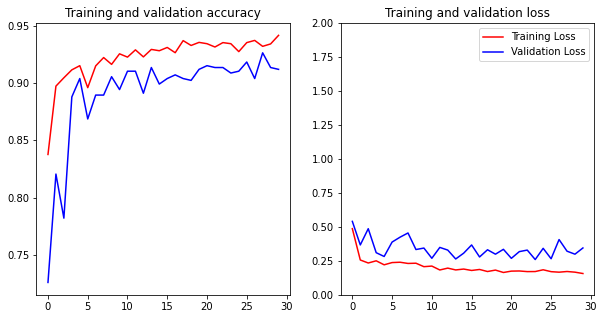

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.subplot(122)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.ylim(0,2)
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
model.save('pneumonia_vs_normal9491.h5')